# Importación modulos y datos

In [37]:
import numpy as np
import pandas as pd
import matplotlib 

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import datasets
from sklearn.preprocessing import normalize


matplotlib.style.use('ggplot')
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [51]:
data = pd.read_csv("../data/conchillas_merge.csv", low_memory = False, keep_default_na = False, na_values = '')
data.head(5)

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,Labio,cox1-lsu
0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,LU,1.0,AA
1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,LU,1.0,HG
2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,1.0,NaN
3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,0.0,NaN
4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,LU,1.0,HG


# Exploración y limpieza de datos

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Lote       423 non-null    int64  
 1   Individuo  423 non-null    int64  
 2   AE         423 non-null    float64
 3   LE         423 non-null    float64
 4   AT         423 non-null    float64
 5   LT         423 non-null    float64
 6   AA         423 non-null    float64
 7   LA         423 non-null    float64
 8   NV         423 non-null    float64
 9   Morfotipo  423 non-null    object 
 10  Labio      422 non-null    float64
 11  cox1-lsu   106 non-null    object 
dtypes: float64(8), int64(2), object(2)
memory usage: 39.8+ KB


In [53]:
data.rename(columns = {'cox1-lsu': 'cox1-rrnL'}, inplace = True)
data["Labio"][6] = 0

<ipython-input-53-ebcdec593805>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Labio"][6] = 0


In [54]:
# No hay individuos juveniles en el dataset (ancho total menor a 8 milímetros o ausencia de labio)

len(np.logical_or(data.Labio == 1, data.AT >= 8)) == len(data)

True

In [55]:
medidas = list(data.columns[2:-3])
data[medidas].describe()

,AE,LE,AT,LT,AA,LA,NV
count,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000,423.000000
mean,6.241608,1.763570,13.270284,9.780260,7.695130,6.265035,5.145248
std,0.980104,0.375682,1.941412,1.435288,1.233105,0.913267,0.297400
min,3.200000,0.710000,8.050000,6.170000,4.790000,4.270000,4.020000
25%,5.585000,1.500000,11.790000,8.780000,6.770000,5.605000,4.950000
50%,6.250000,1.760000,13.220000,9.690000,7.610000,6.150000,5.180000
75%,6.905000,2.030000,14.585000,10.830000,8.550000,6.790000,5.340000
max,9.040000,3.130000,19.090000,14.450000,11.950000,9.720000,5.950000


In [56]:
round(data['Morfotipo'].value_counts(normalize = True)*100, 2)
data['cox1-rrnL'].value_counts()

LU    86.05
LB    13.24
DU     0.71
Name: Morfotipo, dtype: float64

AA    68
HG    10
GF     3
BA     3
GC     3
LA     3
CA     2
OA     2
GE     2
MG     1
IG     1
DA     1
KI     1
JH     1
NA     1
FA     1
AB     1
GD     1
EA     1
Name: cox1-rrnL, dtype: int64

### Creación columnas nuevas

In [57]:
# Creación de diccionario y reemplazo de haplotipos combinados (105) por haplogrupos (3)
ht = ['AA', 'AB', 'BA', 'CA', 'DA', 'EA', 'FA', 'LA', 'NA', 'OA', 'JH', 'KI', 'GC', 'GD', 'GE', 'GF', 'HG', 'IG', 'MG']
hg = ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '2', '2', '2']
hg_ht_rep = dict(zip(ht, hg))

data["haplogrupos"] = data["cox1-rrnL"].replace(hg_ht_rep)

In [61]:
data_ratios = pd.DataFrame({'Lote': data.Lote, 'Individuo': data.Individuo, 'cox1-rrnL': data['cox1-rrnL'], 'haplogrupos': data.haplogrupos})
data_ratios

# # Cada parte sobre sí misma
# data["LE/AE"] = data["LE"]/data["AE"] # Espira
# data["LT/AT"] = data["LT"]/data["AT"] # Total
# data["LA/AA"] = data["LA"]/data["AA"] # Abertura

# # Espira / Total
# data["LE/LT"] = data["LE"]/data["LT"] # Largo
# data["AE/AT"] = data["AE"]/data["AT"] # Ancho

# # Abertura / Total
# data["LA/LT"] = data["LA"]/data["LT"] # Largo
# data["AA/AT"] = data["AA"]/data["AT"] # Ancho

# # Espira / Abertura
# data["LE/LA"] = data["LE"]/data["LA"] # Largo
# data["AE/AA"] = data["AE"]/data["AA"] # Ancho

,Lote,Individuo,cox1-rrnL,haplogrupos
0,96,1,AA,0
1,96,2,HG,2
2,96,5,NaN,NaN
3,96,6,NaN,NaN
4,99,1,HG,2
...,...,...,...,...
418,554,5,NaN,NaN
419,554,6,AA,0
420,554,7,NaN,NaN
421,554,8,NaN,NaN


In [112]:
data.head()

,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,Morfotipo,...,haplogrupos,Ratio_LE_AE,Ratio_LT_AT,Ratio_LA_AA,Ratio_LE_LT,Ratio_AE_AT,Ratio_LA_LT,Ratio_AA_AT,Ratio_LE_LA,Ratio_AE_AA
0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,LU,...,0,0.363339,0.744803,0.853480,0.213667,0.437993,0.672762,0.587097,0.317597,0.746032
1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,LU,...,2,0.254833,0.714041,0.913178,0.173861,0.487158,0.706235,0.552226,0.246180,0.882171
2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,LU,...,NaN,0.293160,0.728863,0.747847,0.180000,0.447522,0.608000,0.592566,0.296053,0.755228
3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,LU,...,NaN,0.333333,0.789880,0.740240,0.236699,0.560892,0.535288,0.571184,0.442191,0.981982
4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,LU,...,2,0.262895,0.722002,0.955202,0.173817,0.477363,0.727173,0.549643,0.239032,0.868497


### Relación entre variables

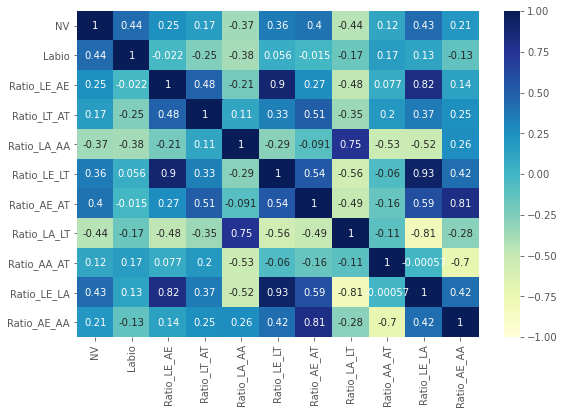

In [113]:
def _print_matriz_correlacion(dflocal):
    plt.rcParams['figure.figsize'] = (9, 6)
    plt.rcParams['font.size'] = 10
    sns.heatmap(dflocal, vmin = -1, vmax = 1, center = 0, cmap = "YlGnBu", annot = True)
_print_matriz_correlacion(data.iloc[8:,8:].corr())  

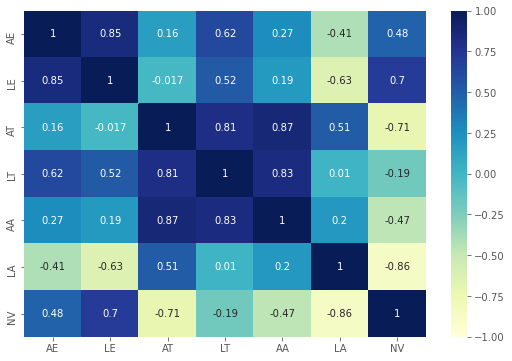

In [114]:
#variables originales del dataset
_print_matriz_correlacion(data.iloc[2:9,2:9].corr())  

### Distribución de las observaciones

In [115]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15, 9))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=10,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  
    plt.show()

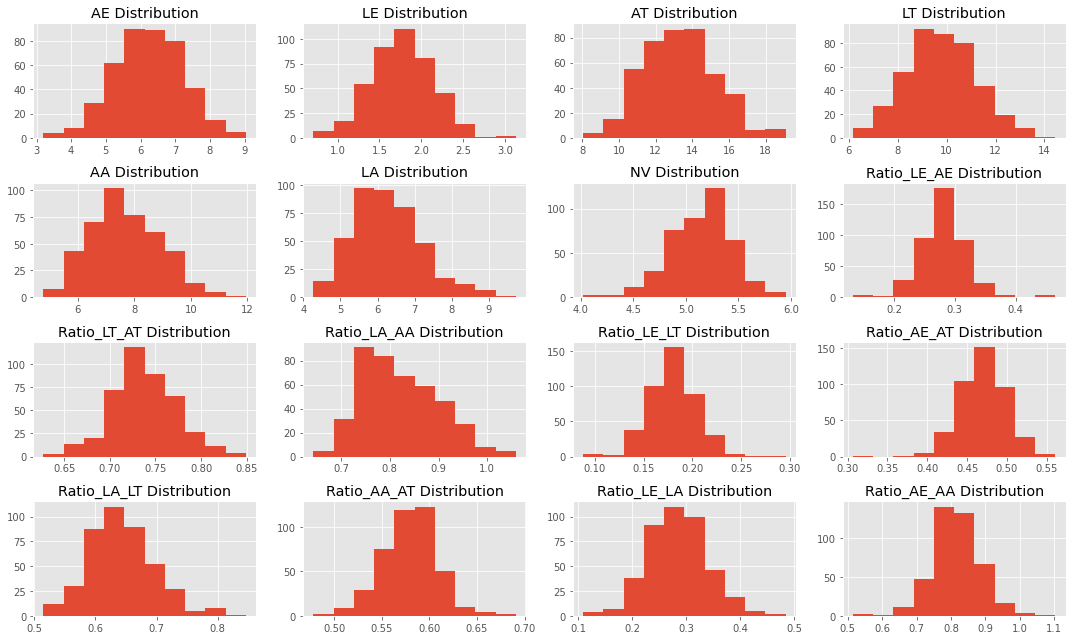

In [116]:
draw_histograms(data, data[['AE','LE','AT','LT','AA','LA','NV','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']], 4, 4)

# Modelos de clustering

## Importación modulos y dataset

In [117]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import silhouette_samples, silhouette_score,calinski_harabasz_score
from scipy.cluster import hierarchy 
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.cm as cm

## Prueba Kmeans

### Con las variables originales

In [118]:
x = data[['AE','LE','AT','LT','AA','LA','NV','Labio']]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x_scaled=scaler.fit_transform(x);

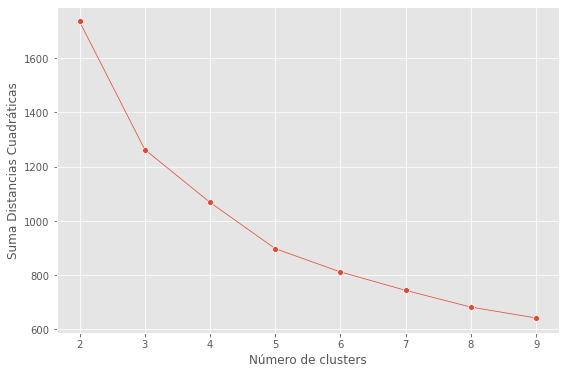

In [119]:
sq_distances=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    sq_distances.append(kmeans.inertia_)

sns.lineplot(x=k_values,y=sq_distances,marker='o',size=30,legend=False);
plt.ylabel('Suma Distancias Cuadráticas');plt.xlabel('Número de clusters'); 

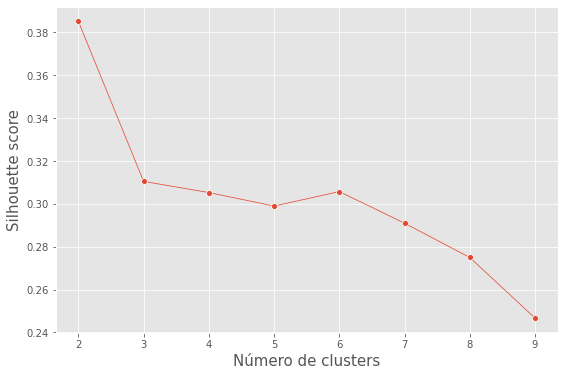

In [120]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_scaled)
    score=silhouette_score(x_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

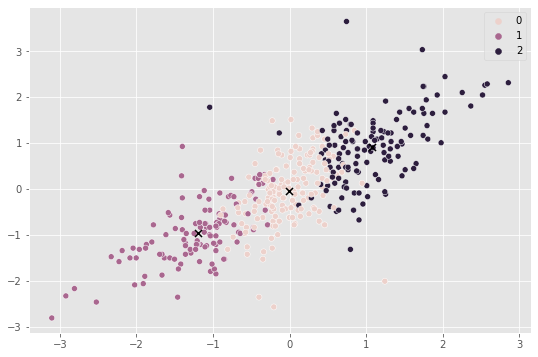

In [121]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_scaled)

labels = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_scaled[:,0],y=x_scaled[:,1],hue=labels,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids[:,0],centroids[:,1],marker='x',s=50,color='k');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

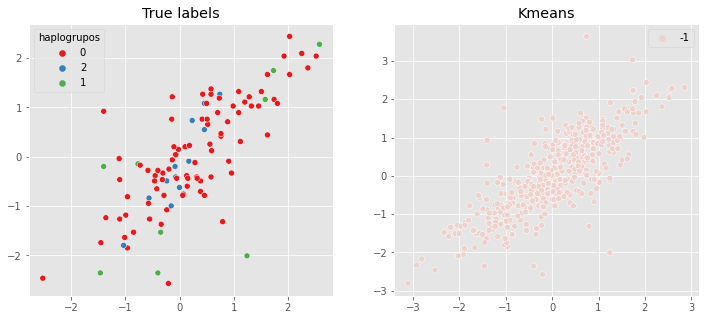

In [176]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans')

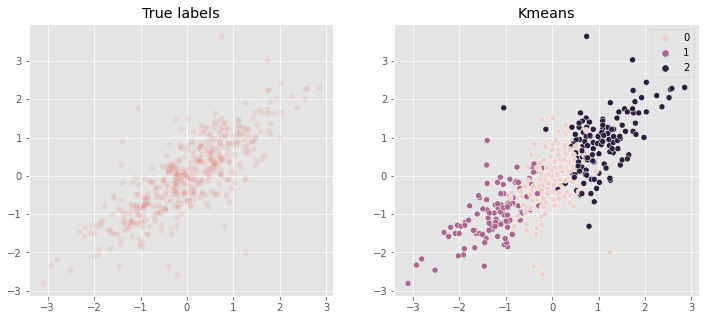

In [123]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],ax=ax[0], alpha=0.1)
#sns.scatterplot(x = x_scaled[indices,0], y = x_scaled[indices,1],hue=y_true[y_true!="0"],ax=ax[0], palette="magma")
ax[0].set_title('True labels')
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=labels,ax=ax[1])
ax[1].set_title('Kmeans')

In [124]:
indices = y_true[y_true!="0"].index

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

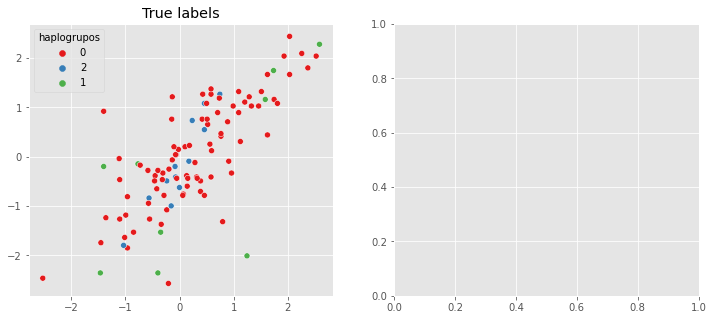

In [175]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_scaled[:,0], y = x_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')

In [126]:
x_scaled.shape
x_scaled[indices].shape

(423, 8)

(338, 8)

In [127]:
x_scaled[indices,0]

array([-5.63471793e-01, -1.03792987e-01,  3.04810396e-01, -2.36589087e-01,
       -7.31477333e-02,  2.33304804e-01,  6.92983610e-01,  2.63950058e-01,
       -1.65083495e-01,  2.63950058e-01, -8.39279077e-01,  5.96483662e-02,
        5.96483662e-02,  1.87880279e-02, -3.28524848e-01,  4.27391411e-01,
       -2.16158917e-01, -1.40110873e+00,  6.98634508e-02,  3.04810396e-01,
       -1.66670093e+00,  7.33843949e-01,  5.29542257e-01,  8.46209879e-01,
        1.87880279e-02, -2.36589087e-01,  1.75535241e+00, -1.64214126e-03,
        3.66100904e-01, -1.54868410e-01, -8.29063992e-01, -4.91966201e-01,
       -1.63605567e+00, -1.61562551e+00, -1.04358077e+00, -7.57558400e-01,
       -1.22745229e+00, -1.08444111e+00, -1.56455008e+00, -2.04465906e+00,
       -1.41132381e+00, -9.10784669e-01, -2.22853058e+00, -2.33068143e+00,
       -2.18767024e+00, -2.92315633e+00,  8.46209879e-01, -3.48955017e-01,
        4.68251750e-01,  6.52123272e-01,  1.32631885e+00,  1.23438309e+00,
        1.98008427e+00,  

In [128]:
x_scaled[indices,1]

array([-0.83565698,  0.0970859 ,  1.10977817, -0.48920962, -0.40926023,
        0.73668102,  0.8965798 ,  0.39023366, -0.06281288,  0.47018305,
       -0.70240799,  0.36358387, -0.06281288,  1.50952512,  0.31028427,
        0.92322959, -0.70240799, -0.88895657, -0.11611247,  0.86993   ,
       -1.87499904,  1.50952512,  0.41688346,  1.26967695,  0.81663041,
        0.17703529,  2.22906962, -0.6224586 ,  1.16307776,  0.8432802 ,
       -0.72905779, -0.06281288, -1.50190189, -0.99555576, -0.99555576,
        0.23033488, -0.75570759, -0.83565698, -1.50190189, -1.28870352,
       -0.6224586 , -0.08946267, -1.58185128, -1.47525209, -1.34200311,
       -2.32804558, -0.08946267,  0.23033488,  0.8432802 ,  0.76333082,
        1.21637736,  0.78998061,  1.00317898,  1.74937329,  0.23033488,
        1.24302715,  0.92322959,  0.55013244,  0.60343204,  0.07043611,
        0.47018305,  0.71003122,  0.57678224,  0.36358387,  0.17703529,
        0.52348265, -0.08946267,  0.39023366,  1.08312837,  0.04

In [35]:
y_true[y_true!="0"]

0       AA
1       HG
2      NaN
3      NaN
4       HG
      ... 
418    NaN
419     AA
420    NaN
421    NaN
422    NaN
Name: cox1-lsu, Length: 423, dtype: object

In [36]:
#sns.heatmap(confusion_matrix(y_true,labels),annot=True,cmap='Blues',fmt=".0f");

#print(classification_report(y_true,labels))

### Con todas las variables

In [129]:
x_R = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]
#x_R = data[['NV','Ratio_AE_LE','Ratio_AA_LA','Ratio_AT_LT']]
y_true = data["haplogrupos"]

scaler = StandardScaler()
x_R_scaled=scaler.fit_transform(x_R);

In [130]:
x_R_scaled.shape

(423, 17)

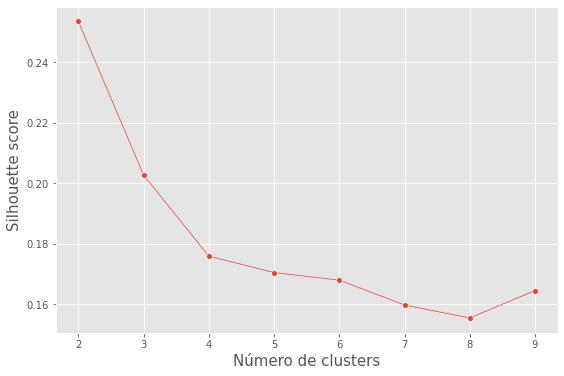

In [131]:
sil=[]
k_values=range(2,10);

for k in k_values:
    kmeans=KMeans(n_clusters=k,n_init=10,random_state=0) # Numero de repeticiones=10
    kmeans.fit(x_R_scaled)
    score=silhouette_score(x_R_scaled,kmeans.labels_)
    sil.append(score)

sns.lineplot(x=k_values,y=sil,marker='o',size=30,legend=False);
plt.ylabel('Silhouette score',fontsize=15);plt.xlabel('Número de clusters',fontsize=15);

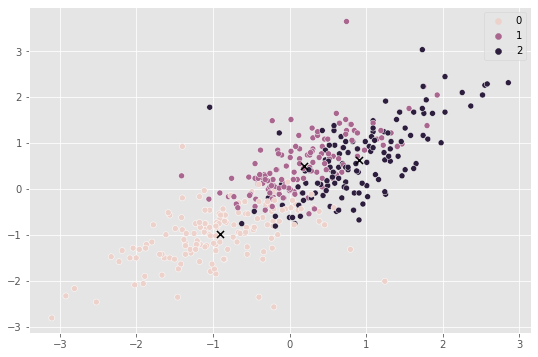

In [132]:
kmeans=KMeans(n_clusters=3,n_init=10,random_state=0) # Numero de repeticiones=10

kmeans.fit(x_R_scaled)

labels_R = kmeans.labels_ # Etiquetas que indican a qué cluster pertenecen los datos
centroids_R = kmeans.cluster_centers_ # Coordenadas de los centroides

sns.scatterplot(x=x_R_scaled[:,0],y=x_R_scaled[:,1],hue=labels_R,legend='full');

#plt.xlabel('Income',fontsize=15);plt.ylabel('Spending Score',fontsize=15);
plt.scatter(centroids_R[:,0],centroids_R[:,1],marker='x',s=50,color='k');

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

<AxesSubplot:>

Text(0.5, 1.0, 'Kmeans_R')

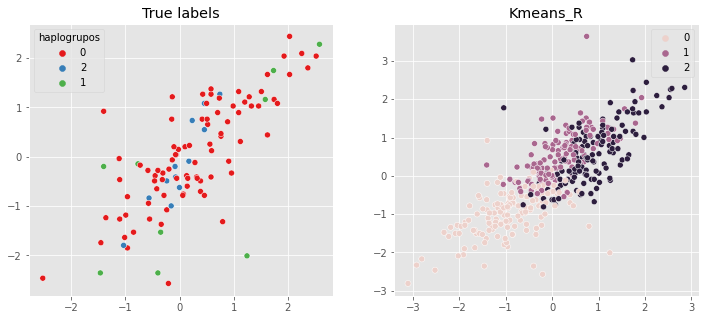

In [170]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=labels_R,ax=ax[1])
ax[1].set_title('Kmeans_R')

<AxesSubplot:>

Text(0.5, 1.0, 'True labels')

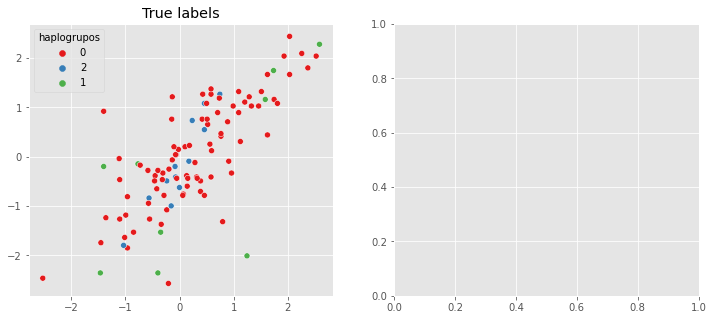

In [164]:
f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')

## DBSCAN

In [135]:
from scipy.spatial.distance import pdist,squareform

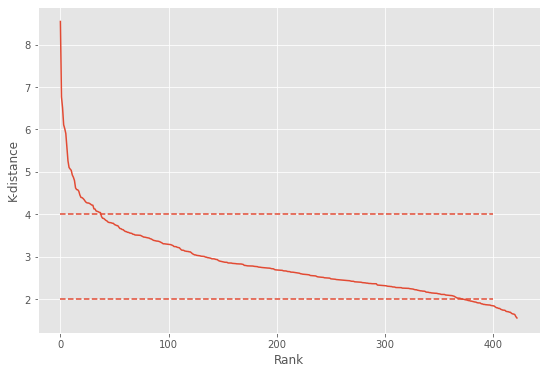

In [136]:
minPts=20;
k=minPts-1;

D=squareform(pdist(x_R_scaled));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([2,4],0,400,linestyles='dashed');

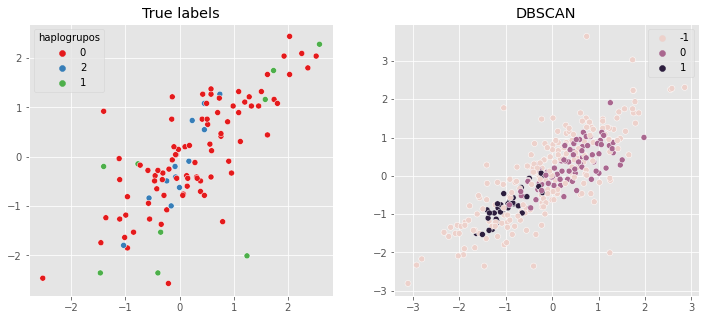

In [169]:
dbscan = DBSCAN(eps=2, min_samples=minPts)
labels_db = dbscan.fit_predict(x_R_scaled[indices])

f,ax=plt.subplots(1,2,figsize=(12,5))
sns.scatterplot(x = x_R_scaled[:,0], y = x_R_scaled[:,1],hue=y_true,ax=ax[0], palette="Set1")
ax[0].set_title('True labels')
sns.scatterplot(x = x_R_scaled[indices,0], y = x_R_scaled[indices,1],hue=labels_db,ax=ax[1])
ax[1].set_title('DBSCAN');


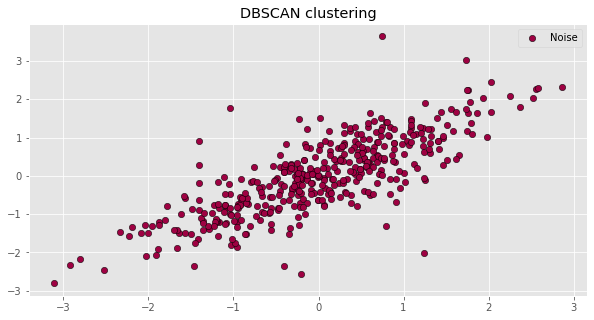

In [138]:
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(x_R_scaled)
y_dbscan


labels = dbscan.labels_
unique_labels=set(labels);

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(x_R_scaled[labels==l,0], x_R_scaled[labels==l,1],color =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

# Modelos reducción dimensionalidad

## Prueba PCA

In [139]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [140]:
std_sclr = StandardScaler()

X = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT',\
          'Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]

data_std = pd.DataFrame(std_sclr.fit_transform(X))

In [141]:
model = PCA()

In [142]:
model_pca = model.fit(data_std)

### Pesos (loadings)

In [143]:
#Creamos un DataFrame con los loadings.
pca_loadings = pd.DataFrame(model_pca.components_.T, index=X.columns).iloc[:,:]
pca_loadings.rename(columns = {0 : 'CP1', 1 : 'CP2', 2 : 'CP3', 3 : 'CP4',4 : 'CP5', 5 : 'CP6', 6 : 'CP7',\
                               7 : 'CP8',8 : 'CP9', 9 : 'CP10', 10 : 'CP11', 11 : 'CP12', 12 : 'CP13', 13 : 'CP14', 14 : 'CP15', 15 : 'CP16', 16 : 'CP17', 17 : 'CP18'}, inplace = True)
pca_loadings

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11,CP12,CP13,CP14,CP15,CP16,CP17
AE,-0.342806,-0.134180,-0.175997,0.076122,-0.103653,-0.087687,-0.112693,0.165605,0.224252,-0.186956,-0.059900,-0.181778,-0.300801,0.640261,-0.137501,-0.063680,0.351998
LE,-0.358815,0.090140,-0.030655,-0.124695,0.191358,-0.044151,-0.048500,0.094433,0.559317,-0.430553,-0.100838,0.225428,0.246535,-0.342270,-0.096930,-0.219021,-0.048049
AT,-0.305473,-0.268078,-0.087810,0.051958,0.073884,-0.183000,0.066390,0.095032,-0.109448,0.091882,0.161357,-0.039614,-0.040140,0.188217,0.149391,-0.315123,-0.751891
LT,-0.334937,-0.187604,-0.097445,-0.127160,-0.052964,-0.119415,0.204618,0.100767,0.032700,-0.042048,0.009492,0.142879,-0.107367,-0.109896,0.224529,0.809555,-0.071628
AA,-0.302987,-0.283165,0.068764,-0.040581,-0.018860,-0.106167,-0.064762,0.111960,-0.225418,0.079199,0.513859,-0.164032,-0.167358,-0.467376,-0.004291,-0.217400,0.389246
LA,-0.214523,-0.328799,-0.230708,-0.268899,0.085569,0.013530,-0.054050,0.080955,-0.282388,0.352459,-0.511673,0.066613,0.408590,-0.004889,-0.172401,-0.083282,0.171796
NV,-0.322713,-0.045897,-0.079880,0.039119,-0.100087,0.119814,-0.086770,-0.923788,0.008912,-0.004134,0.012471,-0.014383,-0.008132,0.004747,0.001594,0.001284,-0.000878
Labio,-0.175042,-0.180105,0.098613,0.352536,0.147413,0.827893,0.274084,0.142121,-0.001850,-0.017938,-0.006524,-0.003481,0.007773,-0.000251,0.003598,-0.002164,0.001329
Ratio_LE_AE,-0.176058,0.307759,0.157611,-0.303059,0.446513,0.038216,0.086129,-0.037694,-0.455746,-0.190527,0.126443,0.421066,-0.177388,0.238306,-0.132918,-0.028445,0.062510
Ratio_LT_AT,-0.091989,0.246209,-0.022754,-0.568225,-0.402553,0.200580,0.439355,0.028995,0.095567,0.102684,-0.052047,-0.117067,-0.114539,0.018981,0.307626,-0.256052,0.040001


<AxesSubplot:xlabel='CP1', ylabel='CP2'>

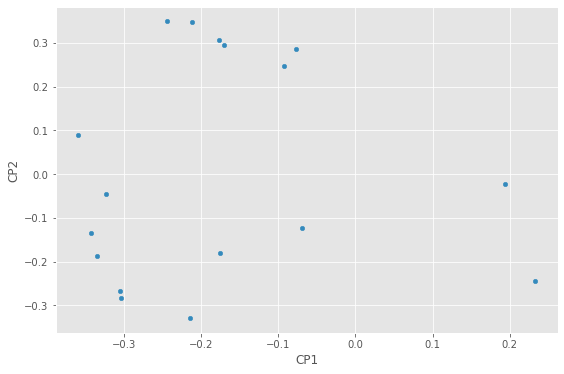

In [144]:
pca_loadings.plot(x="CP1", y="CP2", kind ="scatter")

In [145]:
pca_loadings.T.dot(pca_loadings)

,CP1,CP2,CP3,CP4,CP5,CP6,CP7,CP8,CP9,CP10,CP11,CP12,CP13,CP14,CP15,CP16,CP17
CP1,1.000000e+00,1.804112e-16,2.498002e-16,-2.775558e-17,-8.673617e-17,9.584347e-17,1.647987e-17,-1.222980e-16,-3.139849e-16,-6.938894e-18,-4.510281e-17,-9.887924e-17,-6.245005e-17,-1.370432e-16,7.285839e-17,1.660998e-16,1.578598e-16
CP2,1.804112e-16,1.000000e+00,-5.551115e-16,1.665335e-16,-1.457168e-16,-9.974660e-17,-3.816392e-17,-6.245005e-17,-2.012279e-16,3.816392e-17,1.249001e-16,6.938894e-18,-2.775558e-17,-1.595946e-16,1.665335e-16,4.076600e-17,-3.261280e-16
CP3,2.498002e-16,-5.551115e-16,1.000000e+00,-2.775558e-17,1.387779e-17,5.898060e-17,1.179612e-16,-1.179612e-16,-1.526557e-16,1.144917e-16,2.775558e-17,-1.387779e-16,-5.551115e-17,1.526557e-16,0.000000e+00,-1.621966e-16,-3.330669e-16
CP4,-2.775558e-17,1.665335e-16,-2.775558e-17,1.000000e+00,5.481726e-16,-2.862294e-17,-1.908196e-16,-1.734723e-16,-2.636780e-16,2.636780e-16,-3.053113e-16,1.040834e-16,1.804112e-16,-6.938894e-18,-2.498002e-16,-4.119968e-17,4.718448e-16
CP5,-8.673617e-17,-1.457168e-16,1.387779e-17,5.481726e-16,1.000000e+00,-8.326673e-17,1.110223e-16,-2.706169e-16,-1.353084e-16,-7.112366e-17,1.665335e-16,0.000000e+00,-1.249001e-16,5.204170e-17,4.857226e-17,-5.963112e-17,-9.367507e-17
CP6,9.584347e-17,-9.974660e-17,5.898060e-17,-2.862294e-17,-8.326673e-17,1.000000e+00,1.110223e-16,6.938894e-17,7.372575e-18,9.128982e-17,1.266348e-16,-4.250073e-17,-6.245005e-17,-1.240327e-16,1.162265e-16,-1.602993e-16,-2.428613e-17
CP7,1.647987e-17,-3.816392e-17,1.179612e-16,-1.908196e-16,1.110223e-16,1.110223e-16,1.000000e+00,2.289835e-16,8.760354e-17,3.903128e-17,-1.977585e-16,-7.112366e-17,1.700029e-16,-1.014813e-16,8.673617e-18,1.913617e-16,4.336809e-17
CP8,-1.222980e-16,-6.245005e-17,-1.179612e-16,-1.734723e-16,-2.706169e-16,6.938894e-17,2.289835e-16,1.000000e+00,1.335737e-16,-1.613293e-16,9.020562e-17,7.632783e-17,-4.857226e-17,3.816392e-17,7.632783e-17,2.615096e-16,-1.561251e-16
CP9,-3.139849e-16,-2.012279e-16,-1.526557e-16,-2.636780e-16,-1.353084e-16,7.372575e-18,8.760354e-17,1.335737e-16,1.000000e+00,2.220446e-16,1.387779e-16,-1.387779e-16,8.326673e-17,-1.734723e-16,-4.163336e-17,-2.142383e-16,9.020562e-17
CP10,-6.938894e-18,3.816392e-17,1.144917e-16,2.636780e-16,-7.112366e-17,9.128982e-17,3.903128e-17,-1.613293e-16,2.220446e-16,1.000000e+00,3.573530e-16,-5.551115e-17,-1.734723e-17,-4.250073e-17,-1.734723e-16,2.255141e-17,3.252607e-16


In [146]:
def plot_explained_variance(components_count, X):

    model_pca = PCA(components_count).fit(X)

    explained_variance = model_pca.explained_variance_ratio_

    #print(explained_variance)

    cumulative_explained_variance = np.cumsum(explained_variance)

    #print(cumulative_explained_variance)

    plt.plot(cumulative_explained_variance)
    plt.xlabel('número de componentes')
    plt.ylabel('% de varianza explicada');

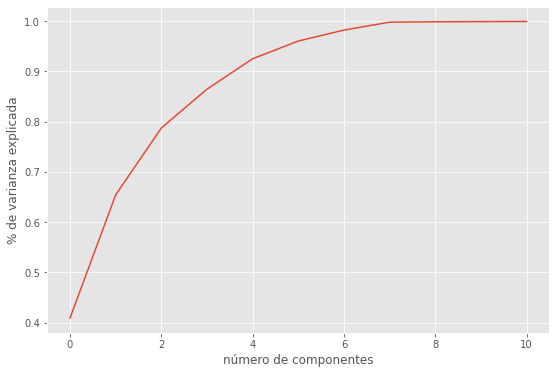

In [147]:
plot_explained_variance(components_count = 11, X = data_std)

### Proyección

In [148]:
#nuevo dataset con cada participación de feature
nuevo_data_pca = pd.DataFrame(model_pca.fit_transform(data_std), index =X.index,\
                              columns=['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6', 'PC7', 'PC8','PC9', 'PC10','PC11','PC12','PC13','PC14','PC15','PC16','PC17'])

In [149]:
nuevo_data_pca.head(10)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,-1.638521,0.028316,0.856264,-1.570099,2.625436,0.782146,0.202524,-0.337322,-0.045283,-0.071513,-0.055691,0.046713,0.018658,-0.001541,-0.003748,-0.016684,0.012072
1,2.284968,0.251741,-1.704825,0.984008,0.233481,1.428868,-0.403115,0.105339,-0.048067,-0.079909,0.036217,0.029437,-0.000913,-0.037839,0.010115,0.009626,-0.015350
2,-0.561589,-0.489340,1.662174,0.472760,0.400637,0.123164,0.594050,0.105269,-0.025041,-0.020942,-0.021458,-0.016614,0.010299,-0.005676,-0.001188,0.003235,0.001675
3,-2.656531,6.042551,-0.405005,0.605171,-1.243740,-0.280021,-0.914127,-0.312975,0.041449,0.388465,0.047207,0.081062,0.018077,-0.036454,0.016073,-0.001221,-0.014981
4,1.531960,-0.555697,-2.259505,0.181240,0.667003,1.430024,-0.265600,-0.183017,0.000538,-0.019760,0.029849,-0.010455,-0.000636,-0.003699,-0.016702,0.014330,-0.016122
5,1.306924,0.659963,-3.120115,1.261114,0.596161,1.396248,-0.548289,-0.197107,-0.072427,-0.099269,0.103544,0.010129,0.059244,0.006042,0.022026,0.015905,-0.008239
6,-0.458398,2.137634,-2.392038,-0.495332,1.042476,-0.411227,-0.855944,-0.227316,-0.024444,-0.055043,0.020456,-0.036212,0.047927,0.005947,0.015944,0.008411,-0.011195
7,-2.158632,1.770249,0.690068,-0.358228,-0.999047,-1.062490,-0.695899,0.355032,0.044935,0.023756,0.015137,0.025408,-0.035689,-0.012701,-0.036557,0.011404,-0.004859
8,-0.329293,3.512222,-3.616412,0.676996,-0.215923,-0.583877,0.313326,-0.327311,-0.059603,-0.029296,0.165377,0.027914,0.185585,0.042940,0.077576,0.000369,0.034527
9,-0.314484,0.525768,1.213980,0.801761,-0.202331,0.737912,-0.241243,-0.156534,-0.059251,-0.041213,-0.028323,-0.013403,0.010549,-0.003859,-0.017842,0.008449,-0.005884


In [150]:
nuevo_data_pca.reset_index()

,index,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17
0,0,-1.638521,0.028316,0.856264,-1.570099,2.625436,0.782146,0.202524,-0.337322,-0.045283,-0.071513,-0.055691,0.046713,0.018658,-0.001541,-0.003748,-0.016684,0.012072
1,1,2.284968,0.251741,-1.704825,0.984008,0.233481,1.428868,-0.403115,0.105339,-0.048067,-0.079909,0.036217,0.029437,-0.000913,-0.037839,0.010115,0.009626,-0.015350
2,2,-0.561589,-0.489340,1.662174,0.472760,0.400637,0.123164,0.594050,0.105269,-0.025041,-0.020942,-0.021458,-0.016614,0.010299,-0.005676,-0.001188,0.003235,0.001675
3,3,-2.656531,6.042551,-0.405005,0.605171,-1.243740,-0.280021,-0.914127,-0.312975,0.041449,0.388465,0.047207,0.081062,0.018077,-0.036454,0.016073,-0.001221,-0.014981
4,4,1.531960,-0.555697,-2.259505,0.181240,0.667003,1.430024,-0.265600,-0.183017,0.000538,-0.019760,0.029849,-0.010455,-0.000636,-0.003699,-0.016702,0.014330,-0.016122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,418,0.006228,0.790069,0.911508,-0.063248,-0.438464,-0.923801,-0.453343,-0.972003,-0.037741,-0.000992,-0.020340,-0.014376,-0.012211,0.000286,-0.013375,0.008718,-0.002566
419,419,-0.941653,1.097568,0.682993,0.122504,-1.173946,0.986678,0.762530,-0.524745,-0.018202,-0.016384,-0.043771,-0.004648,-0.019286,-0.009918,0.024944,-0.007280,0.002654
420,420,-1.757735,2.150779,2.260020,1.039038,-0.343256,0.308474,0.490006,0.077813,0.056453,0.148936,0.010488,0.016724,0.003301,0.013405,-0.052777,0.020539,0.003716
421,421,0.904730,-2.404919,2.039238,0.151798,0.082752,0.394367,0.496658,-1.044139,-0.020271,-0.002491,0.002104,-0.044590,0.050492,-0.011473,0.022913,0.007418,0.012318


In [151]:
data.reset_index()

,index,Lote,Individuo,AE,LE,AT,LT,AA,LA,NV,...,haplogrupos,Ratio_LE_AE,Ratio_LT_AT,Ratio_LA_AA,Ratio_LE_LT,Ratio_AE_AT,Ratio_LA_LT,Ratio_AA_AT,Ratio_LE_LA,Ratio_AE_AA
0,0,96,1,6.11,2.22,13.95,10.39,8.19,6.99,5.30,...,0,0.363339,0.744803,0.853480,0.213667,0.437993,0.672762,0.587097,0.317597,0.746032
1,1,96,2,5.69,1.45,11.68,8.34,6.45,5.89,5.00,...,2,0.254833,0.714041,0.913178,0.173861,0.487158,0.706235,0.552226,0.246180,0.882171
2,2,96,5,6.14,1.80,13.72,10.00,8.13,6.08,5.12,...,NaN,0.293160,0.728863,0.747847,0.180000,0.447522,0.608000,0.592566,0.296053,0.755228
3,3,96,6,6.54,2.18,11.66,9.21,6.66,4.93,5.47,...,NaN,0.333333,0.789880,0.740240,0.236699,0.560892,0.535288,0.571184,0.442191,0.981982
4,4,99,1,6.01,1.58,12.59,9.09,6.92,6.61,5.15,...,2,0.262895,0.722002,0.955202,0.173817,0.477363,0.727173,0.549643,0.239032,0.868497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
418,418,554,5,5.99,1.73,12.72,9.37,7.53,5.77,5.37,...,NaN,0.288815,0.736635,0.766268,0.184632,0.470912,0.615795,0.591981,0.299827,0.795485
419,419,554,6,6.17,1.78,12.63,9.89,7.47,5.80,5.40,...,0,0.288493,0.783056,0.776439,0.179980,0.488519,0.586451,0.591449,0.306897,0.825971
420,420,554,7,6.20,1.95,12.82,9.67,7.67,5.23,5.23,...,NaN,0.314516,0.754290,0.681877,0.201655,0.483619,0.540848,0.598284,0.372849,0.808344
421,421,554,8,5.63,1.48,13.38,9.60,8.14,6.27,5.33,...,NaN,0.262877,0.717489,0.770270,0.154167,0.420777,0.653125,0.608371,0.236045,0.691646


In [152]:
nuevo2= pd.concat([nuevo_data_pca, data["haplogrupos"]], axis=1)

In [153]:
nuevo2.head(5)
#nuevo2.replace("NaN",0)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,haplogrupos
0,-1.638521,0.028316,0.856264,-1.570099,2.625436,0.782146,0.202524,-0.337322,-0.045283,-0.071513,-0.055691,0.046713,0.018658,-0.001541,-0.003748,-0.016684,0.012072,0
1,2.284968,0.251741,-1.704825,0.984008,0.233481,1.428868,-0.403115,0.105339,-0.048067,-0.079909,0.036217,0.029437,-0.000913,-0.037839,0.010115,0.009626,-0.015350,2
2,-0.561589,-0.489340,1.662174,0.472760,0.400637,0.123164,0.594050,0.105269,-0.025041,-0.020942,-0.021458,-0.016614,0.010299,-0.005676,-0.001188,0.003235,0.001675,NaN
3,-2.656531,6.042551,-0.405005,0.605171,-1.243740,-0.280021,-0.914127,-0.312975,0.041449,0.388465,0.047207,0.081062,0.018077,-0.036454,0.016073,-0.001221,-0.014981,NaN
4,1.531960,-0.555697,-2.259505,0.181240,0.667003,1.430024,-0.265600,-0.183017,0.000538,-0.019760,0.029849,-0.010455,-0.000636,-0.003699,-0.016702,0.014330,-0.016122,2


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

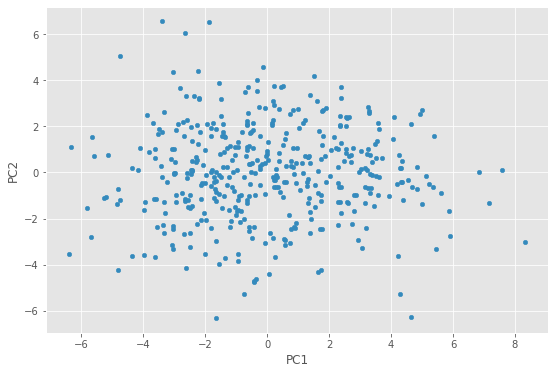

In [154]:
nuevo2.plot(x="PC1", y="PC2", kind ="scatter")

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

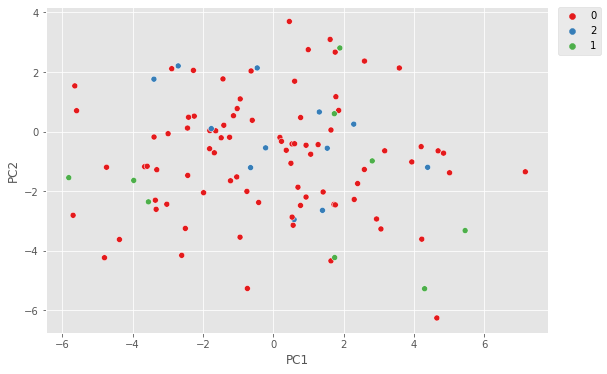

In [177]:
sns.scatterplot(data=nuevo2,x="PC1", y="PC2",hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [179]:
#indices2 = nuevo2[nuevo2["haplogrupos"]!="0"].index

ValueError: Cannot mask with non-boolean array containing NA / NaN values

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

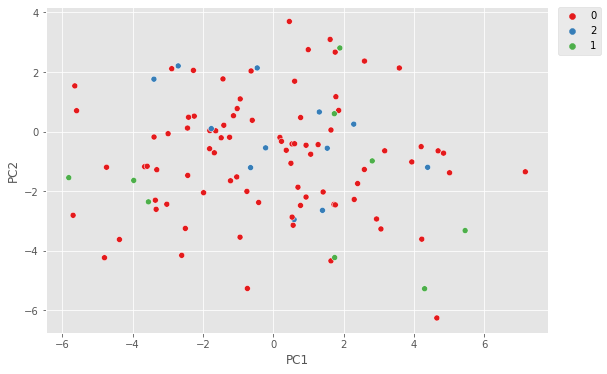

In [182]:
sns.scatterplot(data=nuevo2,x=nuevo2.PC1, y=nuevo2.PC2,hue="haplogrupos", palette="Set1")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [183]:
model_pca.explained_variance_ratio_

array([4.09200885e-01, 2.45066979e-01, 1.33100550e-01, 7.73293898e-02,
       6.05251982e-02, 3.52518378e-02, 2.17761310e-02, 1.57577376e-02,
       7.23158592e-04, 4.37765412e-04, 2.46948130e-04, 1.94355263e-04,
       1.50927263e-04, 1.10636598e-04, 6.60928416e-05, 3.44301713e-05,
       2.69769776e-05])

### Bastón quebrado

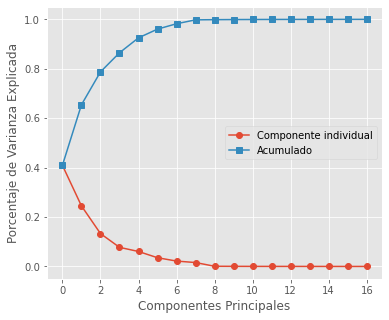

In [184]:
plt.figure(figsize=(6,5))

plt.plot(model_pca.explained_variance_ratio_, '-o', label='Componente individual')
plt.plot(np.cumsum(model_pca.explained_variance_ratio_), '-s', label='Acumulado')

plt.ylabel('Porcentaje de Varianza Explicada'); plt.xlabel('Componentes Principales')
plt.ylim(-0.05,1.05); plt.xticks()
plt.legend(loc=0);

## Prueba TSNE

In [185]:
from sklearn.manifold import TSNE

In [186]:
tsne = TSNE(random_state=42)

proj_tsne = tsne.fit_transform(data_std)

In [187]:
data_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.134438,1.216377,0.350529,0.425324,0.401795,0.794755,0.520965,0.856508,2.185259,0.196783,0.432919,1.385888,-1.126898,0.556346,0.267887,0.632387,-0.991902
1,-0.563472,-0.835657,-0.820108,-1.004653,-1.010947,-0.411139,-0.488972,0.856508,-0.728884,-0.668713,1.201004,-0.238057,0.591529,1.184606,-0.948678,-0.675756,0.996406
2,-0.103793,0.097086,0.231918,0.153279,0.353080,-0.202848,-0.084997,0.856508,0.300454,-0.251693,-0.926155,0.012396,-0.793835,-0.659197,0.458683,0.237765,-0.857597
3,0.304810,1.109778,-0.830422,-0.397785,-0.840444,-1.463555,1.093262,-1.167531,1.379402,1.465046,-1.024030,2.325522,3.168727,-2.023956,-0.287291,2.914587,2.454152
4,-0.236589,-0.489210,-0.350822,-0.481490,-0.629344,0.378173,0.015997,0.856508,-0.512359,-0.444741,1.741688,-0.239833,0.249185,1.577592,-1.038809,-0.806690,0.796705


In [188]:
nuevo3= pd.DataFrame(proj_tsne)

In [189]:
nuevo3.head()

,0,1
0,-8.395551,17.980841
1,10.432178,-1.253162
2,-3.302755,6.692930
3,-15.966346,-3.811686
4,9.953815,-0.237623


In [190]:
nuevo4= pd.concat([nuevo3, data["haplogrupos"]], axis=1)

In [191]:
nuevo4.columns = ["X","Y","haplogrupos"]

In [192]:
nuevo4.head()

,X,Y,haplogrupos
0,-8.395551,17.980841,0
1,10.432178,-1.253162,2
2,-3.302755,6.692930,NaN
3,-15.966346,-3.811686,NaN
4,9.953815,-0.237623,2


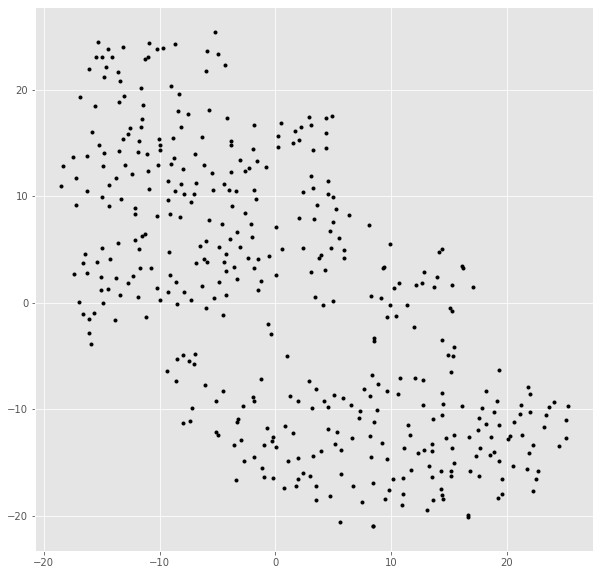

In [193]:
fig, ax = plt.subplots(figsize=(10, 10))

# get axis from plot -  https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.gca.html
ax = ax or plt.gca()
    
coord_x = proj_tsne[:, 0]
coord_y = proj_tsne[:, 1]
ax.plot(coord_x, coord_y, '.k')    

<AxesSubplot:xlabel='X', ylabel='Y'>

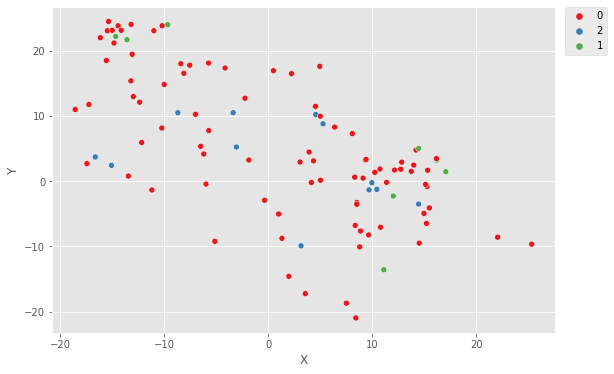

In [196]:
sns.scatterplot(data=nuevo4,x="X", y="Y",hue="haplogrupos",palette="Set1" )
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

# Modelos clasificación

## CART con oversampling target MORFOTIPO

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
newX = data[['AE','LE','AT','LT','AA','LA','NV','Labio','Ratio_LE_AE','Ratio_LT_AT','Ratio_LA_AA','Ratio_LE_LT','Ratio_AE_AT','Ratio_LA_LT','Ratio_AA_AT','Ratio_LE_LA','Ratio_AE_AA']]
newy = data['Morfotipo']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(newX,newy,stratify = data['Morfotipo'],random_state=0)

In [ ]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (317, 17)
Testeo: (106, 17)

Clases train:
LU    0.861199
LB    0.132492
DU    0.006309
Name: Morfotipo, dtype: float64

Clases test:
LU    0.858491
LB    0.132075
DU    0.009434
Name: Morfotipo, dtype: float64


### OverSampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train,y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
DU    273
LU    273
LB     42
Name: Morfotipo, dtype: int64

Composición del test set:
LU    91
LB    14
DU     1
Name: Morfotipo, dtype: int64


In [ ]:
X_train_os2,y_train_os2=oversampler.fit_resample(X_train_os,y_train_os);

print('Composición del training set:')
print(y_train_os2.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
DU    273
LU    273
LB    273
Name: Morfotipo, dtype: int64

Composición del test set:
LU    91
LB    14
DU     1
Name: Morfotipo, dtype: int64


## CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier # to build a classification tree
from sklearn.tree import plot_tree # to draw a classification tree
from sklearn.metrics import plot_confusion_matrix # to draw a confusion matrix
from sklearn.metrics import accuracy_score

### CART con variables originales oversampleadas

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 7, random_state=42)
clf_dt = clf_dt.fit(X_train_os2,y_train_os2)

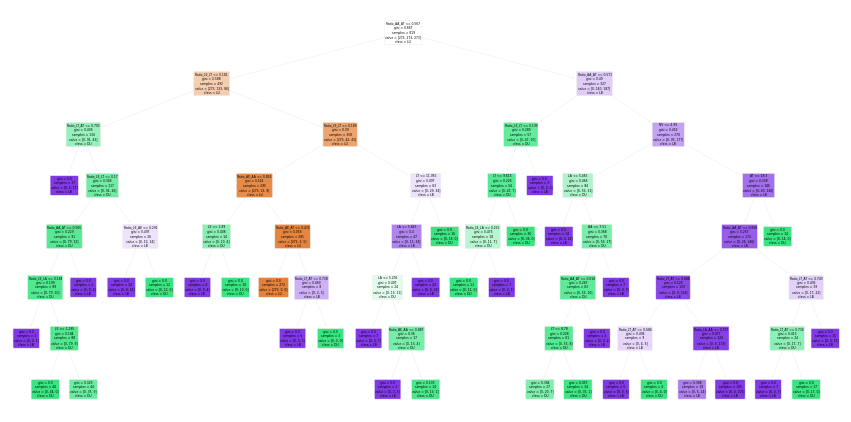

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_os2.columns); 

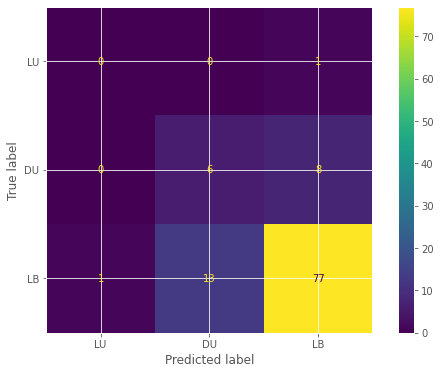

In [ ]:
plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["LU","DU","LB"])

In [ ]:
accuracy_score(y_test, clf_dt.predict(X_test))

0.7830188679245284

### CART con variables de PCA

In [ ]:
X_PCA = nuevo2[['PC1', 'PC2', 'PC3', 'PC4','PC5', 'PC6']]
y_PCA = data['Morfotipo']

In [ ]:
X_train_PCA, X_test_PCA, y_train_PCA, y_test_PCA = train_test_split(X_PCA,y_PCA,stratify = data['Morfotipo'],random_state=0)

In [ ]:
clf_dt = DecisionTreeClassifier(max_depth = 5, random_state=42)
clf_dt = clf_dt.fit(X_train_PCA,y_train_PCA)

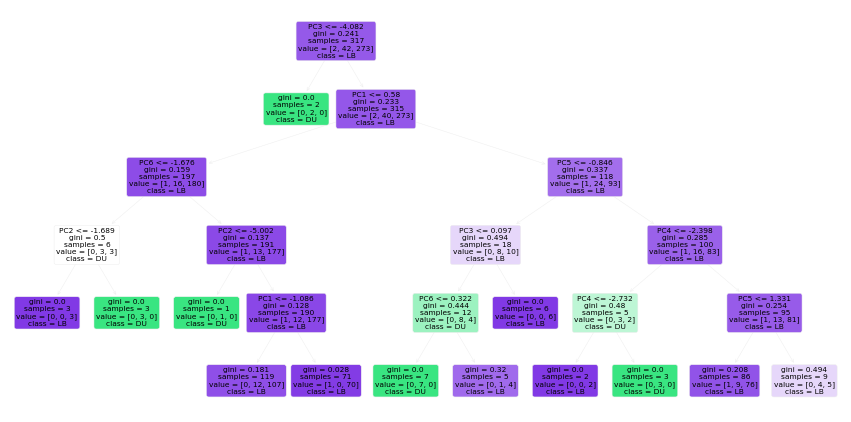

In [ ]:
plt.figure(figsize=(15, 7.5))
plot_tree(clf_dt, 
          filled=True, 
          rounded=True, 
          class_names=["LU","DU", "LB"], 
          feature_names=X_train_PCA.columns); 

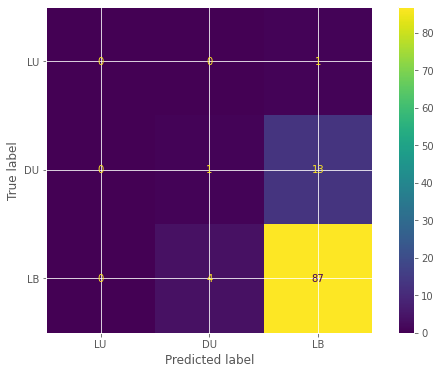

In [ ]:
plot_confusion_matrix(clf_dt, X_test_PCA, y_test_PCA, display_labels=["LU","DU","LB"])

In [ ]:
accuracy_score(y_test_PCA, clf_dt.predict(X_test_PCA))

0.8301886792452831

## XGBoost con variables oversampleadas

In [ ]:
from xgboost import XGBClassifier


In [ ]:
y_train_os2.astype("category")

0      LU
1      LU
2      LB
3      LU
4      LU
       ..
814    LB
815    LB
816    LB
817    LB
818    LB
Name: Morfotipo, Length: 819, dtype: category
Categories (3, object): ['DU', 'LB', 'LU']

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y_train_os2)
y_train_os22 = le.transform(y_train_os2)

LabelEncoder()

In [ ]:
xgboost = XGBClassifier()

In [ ]:
clf_XGB = xgboost.fit(X_train_os2,y_train_os22)

/mnt/Data/ProgramFiles/anaconda3/envs/dhds22/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[11:00:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
accuracy_score(le.transform(y_test), xgboost.predict(X_test))

/mnt/Data/ProgramFiles/anaconda3/envs/dhds22/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


0.8207547169811321